## Oppimisprojekti 3 Whisper-malli

Tämän projektin tarkoitus on käyttää esikoulutettua Whisper-mallia suomenkielisen puheen tunnistamiseen, testata mallia eri puhenäytteillä erilaisissa tilanteissa (melun taso) ja vertailla kahden erikokoisen mallin suorituskykyä.

In [1]:
# Set keras backend to torch
import os; os.environ["KERAS_BACKEND"] = "torch"

##### Importit

In [2]:
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from transformers import WhisperProcessor, WhisperForConditionalGeneration

##### Ääni tiedosto

In [4]:
audio_file = '../week3_sounds/whisper_malli.wav'

In [5]:
# Load file
y, sr = librosa.load(audio_file, sr=16000)

# Display audio for playback
print("Play the audio:")
display(Audio(y, rate=sr))

# Print audio statistics
duration = librosa.get_duration(y=y, sr=sr)
print(f"\nAudio Statistics:")
print(f"Duration: {duration:.2f} seconds")
print(f"Sample rate: {sr} Hz")


Play the audio:



Audio Statistics:
Duration: 16.17 seconds
Sample rate: 16000 Hz


#### Äänitiedostot graafeina

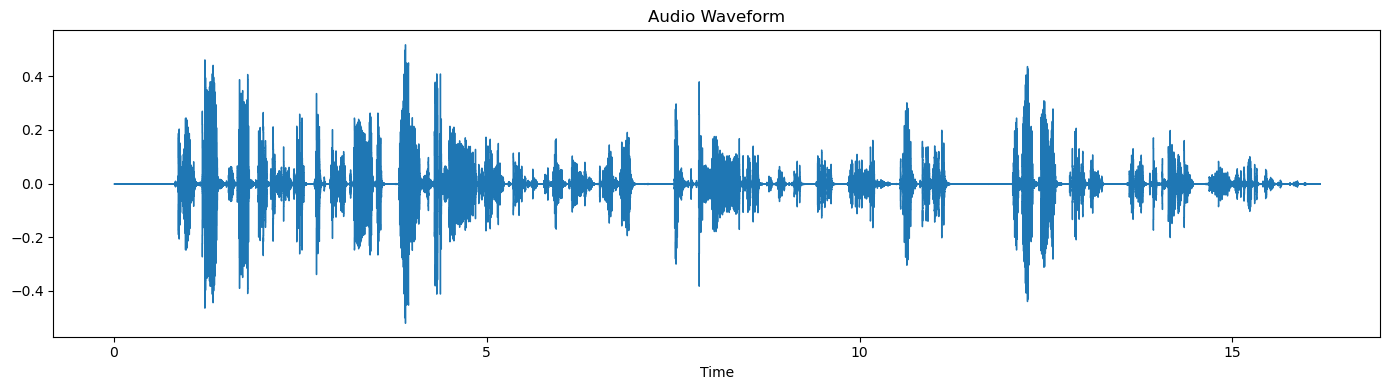

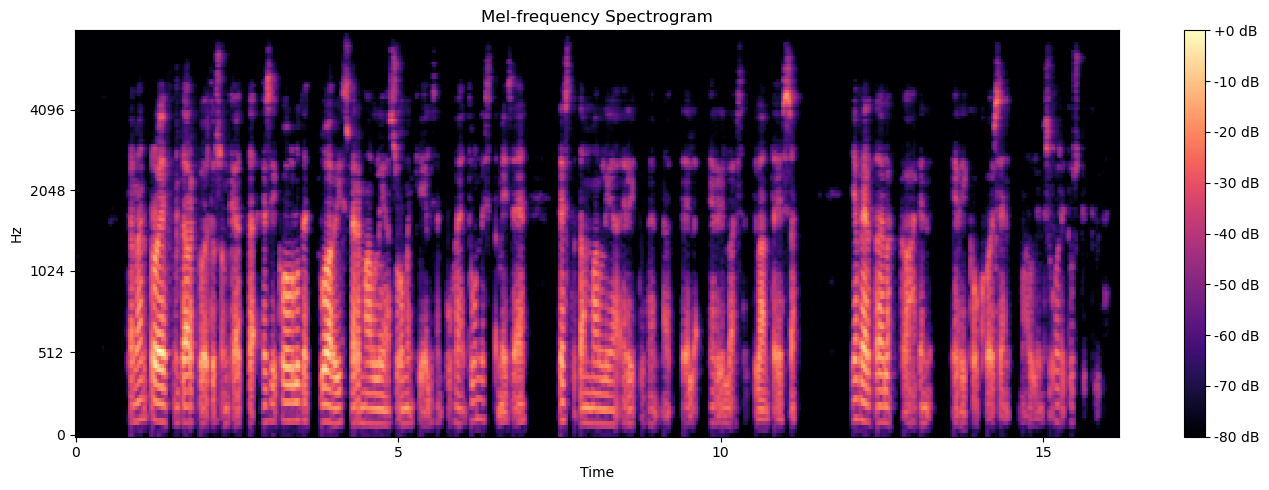

In [6]:
# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.tight_layout()
plt.show()

# Create mel spectrogram
plt.figure(figsize=(14, 5))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, y_axis='mel', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency Spectrogram')
plt.tight_layout()
plt.show()

#### Suomalaisen äänen transkriptio ja käännös Whisper- ja MarianMT-malleilla

In [12]:
from transformers import MarianMTModel, MarianTokenizer

# Load a dedicated Finnish to English translation model
marian_model_name = "Helsinki-NLP/opus-mt-fi-en"
translation_tokenizer = MarianTokenizer.from_pretrained(marian_model_name)
translation_model = MarianMTModel.from_pretrained(marian_model_name)

def transcribe_and_translate(model_size, y, sr):
    print(f"\n===== Using Whisper {model_size.upper()} model =====")
    
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"

    print(f"Using device: {device}")

    # Load model and processor
    model_name = f"openai/whisper-{model_size}"
    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

    # Transcription in Finnish
    forced_decoder_ids_transcribe = processor.get_decoder_prompt_ids(language="fi", task="transcribe")
    input_features = processor(y, sampling_rate=sr, return_tensors="pt").input_features.to(device)

    print("Generating Finnish transcription...")
    with torch.no_grad():
        generated_ids = model.generate(
            input_features,
            forced_decoder_ids=forced_decoder_ids_transcribe
        )

    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    print("\nFINNISH TRANSCRIPTION:")
    print("="*50)
    print(transcription)

    # Translation to English
    forced_decoder_ids_translate = processor.get_decoder_prompt_ids(language="fi", task="translate")

    print("\nGenerating English translation...")
    with torch.no_grad():
        generated_ids = model.generate(
            input_features,
            forced_decoder_ids=forced_decoder_ids_translate
        )

    translation = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    print("\nENGLISH TRANSLATION (Whisper):")
    print("="*50)
    print(translation)

    # Using MarianMT for better translation
    print("\nGenerating better English translation...")
    inputs = translation_tokenizer(transcription, return_tensors="pt")
    translated = translation_model.generate(**inputs)
    better_translation = translation_tokenizer.decode(translated[0], skip_special_tokens=True)

    print("\nBETTER ENGLISH TRANSLATION:")
    print("="*50)
    print(better_translation)

/home/tensor/miniconda3/envs/Torch/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


##### Pieni MarianMT-malli

In [14]:
transcribe_and_translate("tiny", y, sr)


===== Using Whisper TINY model =====
Using device: cuda
Generating Finnish transcription...

FINNISH TRANSCRIPTION:
 Tämän projektun tarkoitus on käyttä, esi koulutet, tuo avis vermalia, suomen kielisen puheen tunnistamiseen, testotammalia erityhänä teillä erillaiset tilanteissa. Ja vertailakkahten erikokoisen mallinen suoritustykille.

Generating English translation...

ENGLISH TRANSLATION (Whisper):
 This project is a project that is very important to the world, and it is very important to the world to the world. It is very important to the world to the world to the world. And it is very important to the world to the world.

Generating better English translation...

BETTER ENGLISH TRANSLATION:
The purpose of this project is to use, preschools, bring avis vermal, to identify Finnish speech, testotammal as a special occasion on your roads.


##### Suuri Whisper-malli

In [15]:
transcribe_and_translate("large", y, sr)


===== Using Whisper LARGE model =====
Using device: cuda
Generating Finnish transcription...

FINNISH TRANSCRIPTION:
 Tämän projektin tarkoitus on käyttää esikoulutettua WISFER-mallia suomenkielisen puheen tunnistamiseen, testata mallia eri puheenäytteillä erilaisissa tilanteissa ja vertailla kahden erikokoisen mallin suorituskykyä.

Generating English translation...

ENGLISH TRANSLATION (Whisper):
 The purpose of this project is to use a pre-trained WISFER model to recognize Finnish-language speech, test the model with different speech patterns in different situations, and compare the performance of two different sizes of the model.

Generating better English translation...

BETTER ENGLISH TRANSLATION:
The purpose of this project is to use the pre-trained WISFER model to identify speech in Finnish, to test the model with different speech samples in different situations and to compare the performance of two models of different sizes.


#### Vertailu

Suuri malli suoriutuu tehtävästä paljon pienempää mallia paremmin, mikä ei tullut yllätyksenä. Tosin huomasimme pienen mallin kanssa ongelman jossa malli jäi välillä toistamaan itseään vastauksissa. Ison mallin kanssa tätä ongelmaa ei tullut. Pieni malli myös tunnistaa sanoja väärin ja hallusinoi omiaan.